In [1]:
%matplotlib inline
import gsc
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(20181107)

In [2]:
# Util

def simplify(sent):
    '''Return a surface string, which is a string of filler names 
    separated by a white space, given a list of terminal binding names.'''
    sent = [bname.split('/')[0] for bname in sent]
    return ' '.join(sent)


def extract_roles(treelet):
    '''Return a list of role names given a list of three binding names'''
    return [bname.split('/')[1] for bname in treelet]


def compute_dist(traj, treelet, metric=['dp', 'edist'][0]):
    '''Return a 1D-array of normalized dot products between 
    intermediate activation state in activation state trajectory `traj` (2D array)
    and discrete activation state `treelet` 
    in a subspace spanning three roles of treelet'''
    
    idx_bindings = net.find_bindings(treelet)
    idx_roles = net.find_roles(extract_roles(treelet))
    ref = np.zeros(net.num_bindings)
    ref[idx_bindings] = 1.
    
    ref = ref[idx_roles]
    traj = traj[:, idx_roles]
    
    if metric == ['dp', 'edist'][0]:
        dist = traj.dot(ref) / len(treelet)
    if metric == ['dp', 'edist'][1]:
        dist = np.sqrt(np.sum((traj - ref[None, :])**2, axis=1)) / np.sqrt(len(idx_roles))
    return dist

    
def get_treelet_label(treelet):
    '''Return a string of treelet label given a list of binding names `treelet`'''
    fnames = simplify(treelet).split(' ')
    return '{m}({l},{r})'.format(m=fnames[2], l=fnames[0], r=fnames[1])


# Default color names
cols = ["#7ccd7c","#FF00FF","#ff6347","#f5bc68"]  ## correct, attraction+ppartitive, attraction+noPpartitive, loc error
colsL = ["#7ccd7c","#f5bc68"]  ## correct, loc error

In [3]:
net = gsc.load_model('../training/s50Gram_nSim70_vSim00.pkl')

In [4]:
print('Number of fillers = {}'.format(net.num_fillers))
print('Number of roles = {}'.format(net.num_roles))

Number of fillers = 27
Number of roles = 10


In [5]:
# Load data
## these are run out to 4000 iters (on one seed)
attraction_errors_collective = np.load('attractionErrorTracesCollective-Best.npy')
attraction_errors_other = np.load('attractionErrorTracesOther-Best.npy')
loc_errors = np.load('locErrorTraces-Best.npy')
correct_trials = np.load('correctTrialTraces-Best.npy')


In [6]:
# Downsampling
interval = 20
attraction_errors_collective = attraction_errors_collective[:, ::interval, :]
attraction_errors_other = attraction_errors_other[:, ::interval, :]
loc_errors = loc_errors[:, ::interval, :]
correct_trials = correct_trials[:, ::interval, :]
data = [correct_trials, attraction_errors_collective, loc_errors, attraction_errors_other]


In [7]:
attraction_errors = attraction_errors_collective

# Construct mean trajectories
correct_trials_mean = correct_trials.mean(axis=0)
attraction_errors_mean = attraction_errors.mean(axis=0)
loc_errors_mean = loc_errors.mean(axis=0)
attraction_errors_other_mean = attraction_errors_other.mean(axis=0)

data_mean = [correct_trials_mean, attraction_errors_mean, attraction_errors_other_mean, loc_errors_mean]
cor_loc_mean = [correct_trials_mean, loc_errors_mean]
cor_attract_mean = [correct_trials_mean, attraction_errors_mean]#, attraction_errors_other_mean]

# SE of activation states over trials at each time point
correct_trials_sd = correct_trials.std(axis=0)
attraction_errors_sd = attraction_errors.std(axis=0)
attraction_errors_other_sd = attraction_errors_other.std(axis=0)
loc_errors_sd = loc_errors.std(axis=0)

data_sd = [correct_trials_sd, attraction_errors_sd, attraction_errors_other_sd, loc_errors_sd]
cor_loc_sd = [correct_trials_sd, loc_errors_sd]
cor_attract_sd = [correct_trials_sd, attraction_errors_sd]#, attraction_errors_other_sd]

# SE of activation states over trials at each time point
correct_trials_se = correct_trials.std(axis=0) / np.sqrt(correct_trials.shape[0])
attraction_errors_se = attraction_errors.std(axis=0) / np.sqrt(attraction_errors.shape[0])
attraction_errors_other_se = attraction_errors_other.std(axis=0) / np.sqrt(attraction_errors_other.shape[0])
loc_errors_se = loc_errors.std(axis=0) / np.sqrt(loc_errors.shape[0])

data_se = [correct_trials_se, attraction_errors_se, attraction_errors_other_se, loc_errors_se]
cor_loc_se = [correct_trials_se, loc_errors_se]
cor_attract_se = [correct_trials_se, attraction_errors_se]#, attraction_errors_other_se]


## Partial activation of bindings

In [8]:
# Activation state trace on 2D subspaces
# Add binding pairs of interest
focus_binding_pairs = [
    ['Ns:1/(1,2)', 'Np:1/(1,2)'],  #preamble error
    ['Np:1/(1,2)', 'Np:0/(1,2)'],  #2nd noun as local or head of RC parse
    ['NPCs[2]:0/(2,1)', 'NPCs[1]:0/(2,1)'],   # NsNp vs. NsNs (preamble error: local noun)
    ['NPCs[2]:0/(2,1)', 'NPCp[3]:0/(2,1)'],   # NsNp-Singular vs. NsNp-Plural (attraction error)
    ['*Vs:1/(2,2)', 'RC[2]:1/(2,2)'],       # correct vs. RC parse
    ['NPCp[3]:0/(2,1)', 'RC[2]:1/(2,2)'],       # NsNp-Plural vs. RC parse
]


focus_binding_pairs_loc = [
    ['Np:1/(1,2)','Ns:1/(1,2)'],  #preamble error
    ['NPCs[2]:0/(2,1)', 'NPCs[1]:0/(2,1)'],   # NsNp vs. NsNs (preamble error: local noun)
]

focus_binding_pairs_attract = [
    ['Np:1/(1,2)', 'Np:0/(1,2)'],  #2nd noun as local or head of RC parse
    ['NPCs[2]:0/(2,1)', 'NPCp[3]:0/(2,1)'],   # NsNp-Singular vs. NsNp-Plural (attraction error)
    ['*Vs:1/(2,2)', 'RC[2]:1/(2,2)'],       # correct vs. RC parse
    ['NPCp[3]:0/(2,1)', 'RC[2]:1/(2,2)'],       # NsNp-Plural vs. RC parse
]


labels = ['Correct', 'Verb Error, Pseudopartitive', 'Verb Error, No Pseudopartitive','Local Noun Error']
labels_loc = ['Correct', 'Local Noun Error']
labels_attract = ['Correct', 'Verb Error, Pseudopartitive']#, 'Verb Error, No Pseudopartitive']

labels_binding_pairs = [
    ['Ns:1', 'Np:1'],  #preamble error
    ['Np:1', 'Np:0'],  #RC parse
    ['NPs[Ns Np]', 'NPs[Ns Ns]'],   # NsNp vs. NsNs (preamble error: local noun)
    ['NPs[Ns Np]', 'NPp[Ns Np]'],   # NsNp-Singular vs. NsNp-Plural (attraction error)
    ['Vs', 'RCp'],       # correct vs. RC parse
    ['NPp[Ns Np]', 'RCp'],       # NsNp-Plural vs. RC parse
]


labels_binding_pairs_loc = [
    ['Np:1','Ns:1'],  #preamble error
    ['NPs[Ns Np]', 'NPs[Ns Ns]']   # NsNp vs. NsNs (preamble error: local noun)
]

labels_binding_pairs_attract = [
    ['[NPsp _ N$p$]', '[RCp Np _]'],  #RC parse
    ['[NPs Ns Np]', '[NPp Ns Np]'],   # NsNp-Singular vs. NsNp-Plural (attraction error)
    ['Vs', 'RCp[]'],       # correct vs. RC parse
    ['[NPp Ns Np]', 'RCp[]'],       # NsNp-Plural vs. RC parse
]




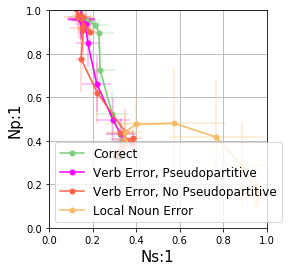

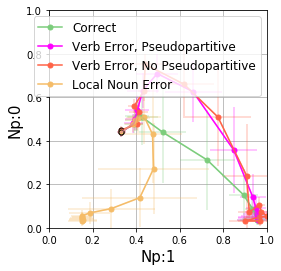

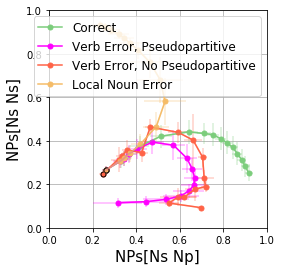

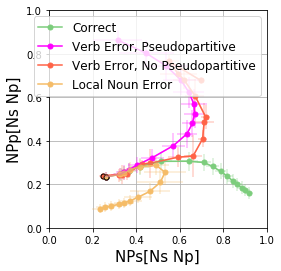

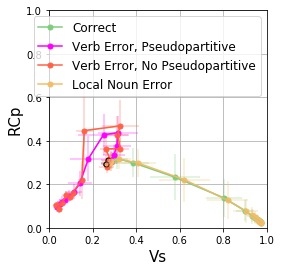

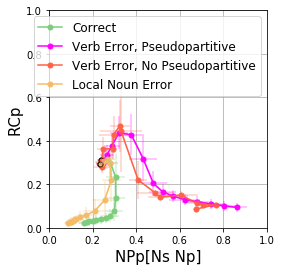

In [9]:
# Mean and SD (or SE) of activation states at different time points
for i, bnames in enumerate(focus_binding_pairs):
    idx = net.find_bindings(bnames)
    for ii, traj in enumerate(data_mean):
        plt.plot(traj[::10, idx[0]], traj[::10, idx[1]], 
                 '.-', markersize=10, color=cols[ii], label=labels[ii])
        plt.errorbar(traj[::10, idx[0]], traj[::10, idx[1]], color=cols[ii], 
                     xerr=data_sd[ii][::10, idx[0]],   # alternatively, use data_se
                     yerr=data_sd[ii][::10, idx[1]],   # alternatively, use data_se
                     alpha=0.3)
        plt.plot(traj[0, idx[0]], traj[0, idx[1]], '.', markersize=10, color='black', fillstyle='none')
    plt.xlabel(labels_binding_pairs[i][0], fontsize=15)
    plt.ylabel(labels_binding_pairs[i][1], fontsize=15)
#    plt.xlabel ('Target Structure',fontsize=15)
#    plt.ylabel ('Similar Non-Target Structure',fontsize=15)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(fontsize=12)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')
    fn = ('Fireworks_NsNp_CorVerLoc'+str(i)+'.png')
    plt.savefig(fname=fn)
    plt.show()
    

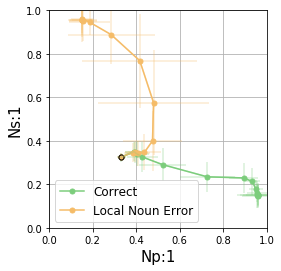

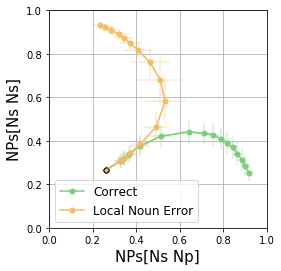

In [10]:
# Mean and SD (or SE) of activation states at different time points
for i, bnames in enumerate(focus_binding_pairs_loc):
    idx = net.find_bindings(bnames)
    for ii, traj in enumerate(cor_loc_mean):
        plt.plot(traj[::10, idx[0]], traj[::10, idx[1]], 
                 '.-', markersize=10, color=colsL[ii], label=labels_loc[ii])
        plt.errorbar(traj[::10, idx[0]], traj[::10, idx[1]], color=colsL[ii], 
                     xerr=cor_loc_sd[ii][::10, idx[0]],   # alternatively, use data_se
                     yerr=cor_loc_sd[ii][::10, idx[1]],   # alternatively, use data_se
                     alpha=0.3)
        plt.plot(traj[0, idx[0]], traj[0, idx[1]], '.', markersize=10, color='black', fillstyle='none')
    plt.xlabel(labels_binding_pairs_loc[i][0], fontsize=15)
    plt.ylabel(labels_binding_pairs_loc[i][1], fontsize=15)
#    plt.xlabel ('Target Structure',fontsize=15)
#    plt.ylabel ('Similar Non-Target Structure',fontsize=15)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(fontsize=12)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')
    fn = ('Fireworks_NsNp_CorLoc'+str(i)+'.png')
    plt.savefig(fname=fn)
    plt.show()
    

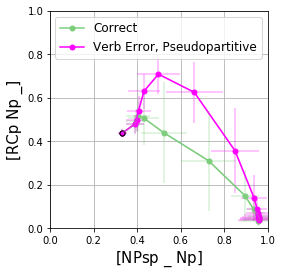

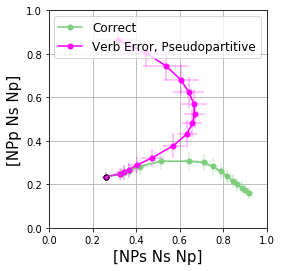

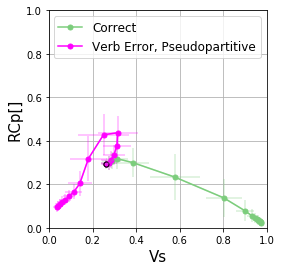

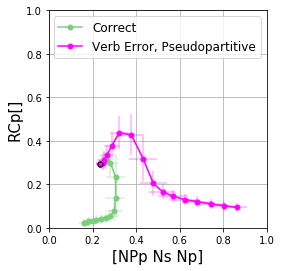

In [11]:
# Mean and SD (or SE) of activation states at different time points
for i, bnames in enumerate(focus_binding_pairs_attract):
    idx = net.find_bindings(bnames)
    plt.rcParams.update({'mathtext.default':  'regular' })
    for ii, traj in enumerate(cor_attract_mean):
        plt.plot(traj[::10, idx[0]], traj[::10, idx[1]], 
                 '.-', markersize=10, color=cols[ii], label=labels_attract[ii])
        plt.errorbar(traj[::10, idx[0]], traj[::10, idx[1]], color=cols[ii], 
                     xerr=cor_attract_sd[ii][::10, idx[0]],   # alternatively, use data_se
                     yerr=cor_attract_sd[ii][::10, idx[1]],   # alternatively, use data_se
                     alpha=0.3)
        plt.plot(traj[0, idx[0]], traj[0, idx[1]], '.', markersize=10, color='black', fillstyle='none')
    plt.xlabel(labels_binding_pairs_attract[i][0], fontsize=15)
    plt.ylabel(labels_binding_pairs_attract[i][1], fontsize=15)
#    plt.xlabel ('Target Structure',fontsize=15)
#    plt.ylabel ('Similar Non-Target Structure',fontsize=15)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(fontsize=12)
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')
    fn = ('Fireworks_NsNp_CorVerb'+str(i)+'.png')
    plt.savefig(fname=fn)
    plt.show()
    